# `Очистка данных`
____
## <a>Содержание</a>
- #### [Разведывательный анализ](#an)
- #### [Пропуски](#drop)
- #### [Выбросы](#out)



___
## <a id='an'>$$Разведывательный \ анализ$$</a>
___

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/sber_data.csv')
display(df.head(2))
df.info()


,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
0,1,43,27.0,4.0,Bibirevo,5001.0,5,11065.0,5,0,...,0.637189,0.947962,0.177975,0.625783,0.628187,14.053047,7.389498,good,0,5850000
1,2,34,19.0,3.0,Nagatinskij Zaton,3119.0,5,6237.0,8,0,...,0.688796,1.072315,0.273345,0.967821,0.471447,6.829889,0.709260,excellent,0,6000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Data columns (total 61 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     30471 non-null  int64  
 1   full_sq                                30471 non-null  int64  
 2   life_sq                                24088 non-null  float64
 3   floor                                  30304 non-null  float64
 4   sub_area                               30471 non-null  object 
 5   preschool_quota                        23783 non-null  float64
 6   preschool_education_centers_raion      30471 non-null  int64  
 7   school_quota                           23786 non-null  float64
 8   school_education_centers_raion         30471 non-null  int64  
 9   school_education_centers_top_20_raion  30471 non-null  int64  
 10  hospital_beds_raion                    16030 non-null  float64
 11  he

___
Постройте коробчатую диаграмму цен на квартиры (price_doc) в зависимости от уровня экологической обстановки в районе (ecology).  
 Какой уровень ценится на рынке меньше всего?

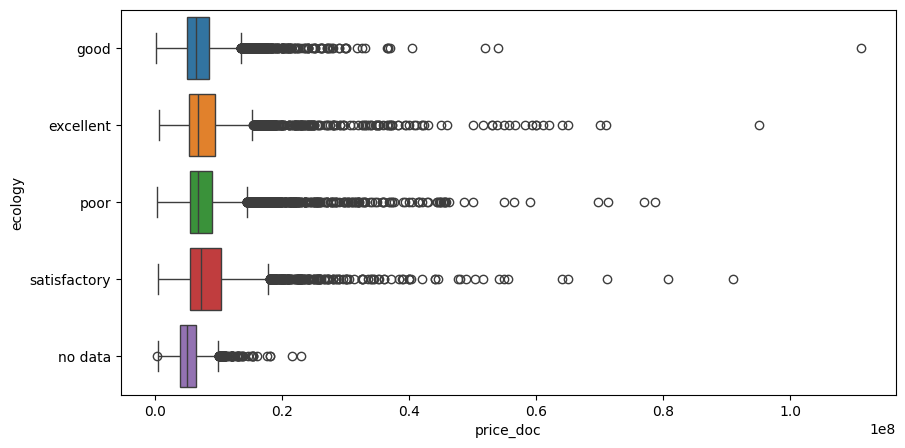

In [2]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(df,x='price_doc', y='ecology' ,orient='h', hue='ecology');


___
Постройте диаграмму рассеяния, которая покажет, как цена на квартиру (price_doc) связана с расстоянием до центра Москвы (kremlin_km).  
Выберите все верные утверждения.

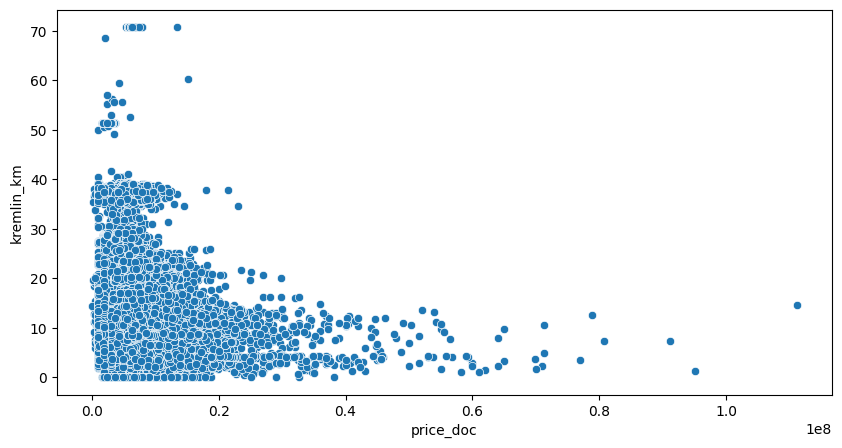

In [3]:
fig = plt.figure(figsize=(10,5))
sns.scatterplot(df,x='price_doc', y='kremlin_km');


___
## <a id='drop'>$$Пропуски$$</a>
___

___
### `Кол-во пропусков в столбцах`
- Абсолютное кол-во

In [4]:
nan_columns = df.isnull().sum().sort_values(ascending=False)
nan_columns = nan_columns[nan_columns > 0]
nan_columns


hospital_beds_raion          14441
preschool_quota               6688
school_quota                  6685
life_sq                       6383
floor                          167
railroad_station_walk_km        25
railroad_station_walk_min       25
metro_min_walk                  25
metro_km_walk                   25
dtype: int64

- Относительное количество

In [5]:
nan_columns = df.isnull().mean().sort_values(ascending=False)*100
nan_columns = nan_columns[nan_columns > 0]
nan_columns


hospital_beds_raion          47.392603
preschool_quota              21.948738
school_quota                 21.938893
life_sq                      20.947786
floor                         0.548062
railroad_station_walk_km      0.082045
railroad_station_walk_min     0.082045
metro_min_walk                0.082045
metro_km_walk                 0.082045
dtype: float64

___
### `Тепловая карта с пропусками`

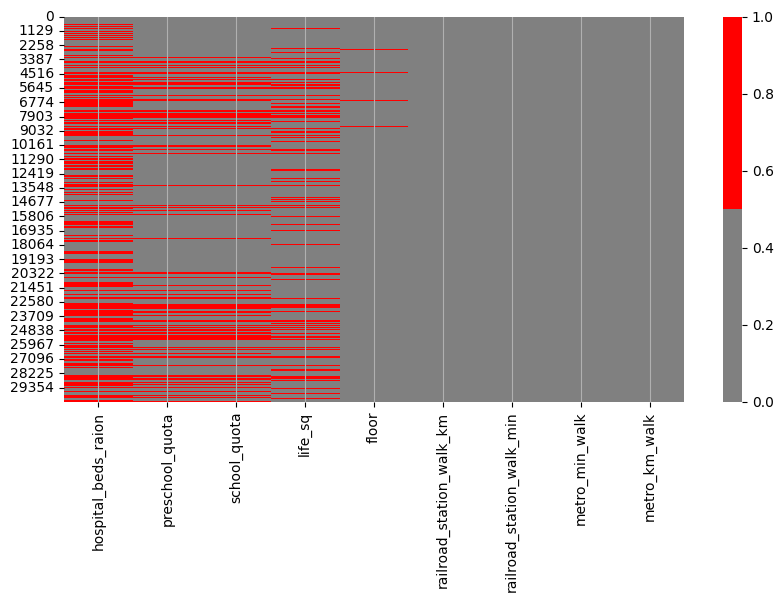

In [6]:
colors = ['grey', 'red']
fig = plt.figure(figsize=(10,5))
columns = nan_columns.index
ax = sns.heatmap(df[columns].isnull(), cmap=sns.color_palette(colors))
ax.grid()
plt.grid(axis='y')


___
### `Удаление столбцов с > 30% пропусков`

In [7]:
df_dropped_na = df.copy()

df_dropped_na.dropna(thresh=df_dropped_na.shape[0]*0.7, axis=1, inplace=True)
df_dropped_na.shape


(30471, 60)

___
### `Удаление строк с > 2 пропусками`

In [8]:
df_dropped_na.dropna(thresh=df_dropped_na.shape[1]-2, axis=0, inplace=True)
df_dropped_na.shape


(26800, 60)

___
### `Заполнение пропусков значениями`

In [9]:
fill_values = {
    'life_sq': df_dropped_na['full_sq'],
    'preschool_quota' : df_dropped_na['preschool_quota'].mode()[0],
    'school_quota' : df_dropped_na['school_quota'].mode()[0],
    'metro_km_walk': df_dropped_na['metro_km_walk'].median(),
    'floor': df_dropped_na['floor'].mode()[0],
    'metro_min_walk' : df_dropped_na['metro_min_walk'].median(),
    'railroad_station_walk_km': df_dropped_na['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': df_dropped_na['railroad_station_walk_min'].median()
}

df_dropped_na.fillna(fill_values, inplace=True)

df_dropped_na.isna().mean().sort_values(ascending=False)[:4]


id                                   0.0
full_sq                              0.0
public_transport_station_min_walk    0.0
mkad_km                              0.0
dtype: float64

___
## <a id='out'>$$Выбросы$$</a>
___

### `МЕТОД МЕЖКВАРТИЛЬНОГО РАЗМАХА (МЕТОД ТЬЮКИ)`

$Граница_{нижняя} = Q_{25} - IQR \cdot  1.5$  
$Граница_{верхняя} = Q_{75} + IQR \cdot  1.5$  
$IQR = Q_{75} - Q_{25}$


In [10]:
def outliers_iqr(data: pd.DataFrame, feature : str, left:float=1.5, right:float=1.5, log_scale:bool=False) -> tuple:
    """Очищает датафрейм от выбросов по методу Тьюки

    Args:
        data (pd.DataFrame): датафрейм
        feature (str): столбец
        left (float, optional): число влево от IQR. Defaults to 1.5.
        right (float, optional): число вправо от IQR. Defaults to 1.5.

    Returns:
        tuple: датафрейм с выбросами,
        очищенный датафрейм от выбросов
    """
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quant_25, quant_75 = x.quantile(0.25), x.quantile(0.75)
    IQR = quant_75 - quant_25
    bond_low = quant_25 - IQR * left
    bond_up = quant_75 + IQR * right
    outliers = data[ (x < bond_low )| (x > bond_up )]
    cleaned_data = data[(x >= bond_low) & (x <= bond_up)]
    return outliers, cleaned_data

data = outliers_iqr(df, 'full_sq', 1, 6 )
data[0].shape[0]


59

___
### `МЕТОД Z-ОТКЛОНЕНИЙ (МЕТОД СИГМ)`
Если распределение нормальное, то 99% значений лежат в интервале $(\mu - 3\sigma; \mu + 3\sigma)$

In [11]:
def outliers_z_score(data:pd.DataFrame, feature:str, log_scale:bool=False, left:float=3, right:float=3) -> tuple:
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = np.mean(x)
    sigma = np.std(x)
    bond_low = mu - sigma*left
    bond_up = mu + sigma*right
    outliers = data[(x < bond_low) | (x > bond_up)]
    data_cleaned = data[(x >= bond_low) & (x <= bond_up)]
    return outliers, data_cleaned

out = outliers_z_score(df, 'mkad_km', True, 3,3.5)
out[1].head()


,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
0,1,43,27.0,4.0,Bibirevo,5001.0,5,11065.0,5,0,...,0.637189,0.947962,0.177975,0.625783,0.628187,14.053047,7.389498,good,0,5850000
1,2,34,19.0,3.0,Nagatinskij Zaton,3119.0,5,6237.0,8,0,...,0.688796,1.072315,0.273345,0.967821,0.471447,6.829889,0.709260,excellent,0,6000000
2,3,43,29.0,2.0,Tekstil'shhiki,1463.0,4,5580.0,7,0,...,1.543049,0.391957,0.158072,3.178751,0.755946,4.273200,3.156423,poor,0,5700000
3,4,89,50.0,9.0,Mitino,6839.0,9,17063.0,10,0,...,0.934273,0.892674,0.236455,1.031777,1.561505,16.990677,16.041521,good,0,13100000
4,5,77,77.0,4.0,Basmannoe,3240.0,7,7770.0,9,0,...,0.077901,0.810801,0.376838,0.378756,0.121681,1.112486,1.800125,excellent,0,16331452


___
### Построение гистограммы в `логарифмическом масштабе`

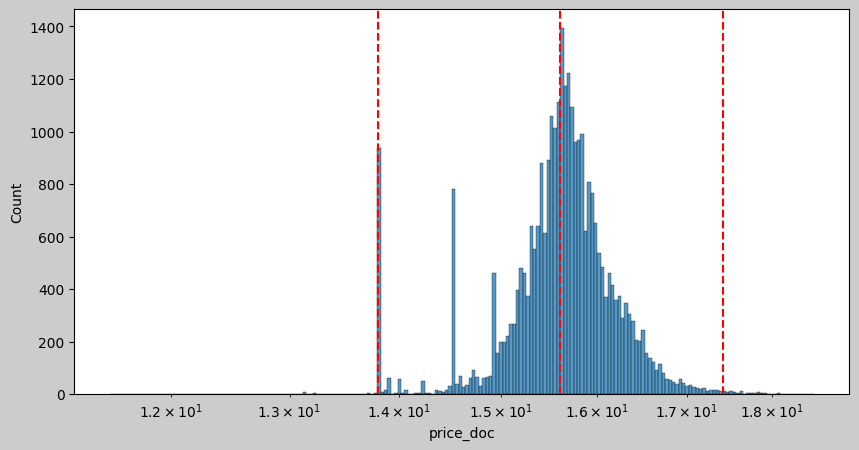

In [12]:
price_log = np.log(df['price_doc'])
price_mean = np.mean(price_log)
sigma = np.std(price_log)

fig = plt.figure(figsize=(10,5), facecolor=(0.8,0.8,0.8))
sns.histplot(x= price_log, log_scale=True);
plt.axvline(price_mean - 3*sigma, ls='--', c='r')
plt.axvline(price_mean + 3*sigma, ls='--', c='r')
plt.axvline(price_mean, ls='--', c='r');


In [13]:
price_out = outliers_z_score(df, 'price_doc', log_scale=True)
price_out[0].sort_values(by='price_doc')['price_doc']


20244       100000
1167        190000
1169        200000
9221        260000
3258        300000
           ...    
6319      78802248
19095     80777440
7457      91066096
28326     95122496
2118     111111112
Name: price_doc, Length: 146, dtype: int64

___
## <a id='do'>$$Дубликаты$$</a>
___

___
### Проверка `столбца идентификатора`

In [14]:
df['id'].nunique() == df.shape[0]


True

___
### Проверка `за исключением` столбца идентификатора

In [15]:
columns_dupl = list(df.columns)
columns_dupl.remove('id')

mask = df.duplicated(subset=columns_dupl)
duplicated = df[mask]
duplicated.shape[0]


562

___
### `Удаление `дубликатов

In [16]:
df_dedupled = df.drop_duplicates(subset=columns_dupl)
df_dedupled.shape[0]


29909

___
## <a id='do'>$$Неинформативные \ признаки$$</a>
Признаки, состоящие из значений повторяющихся на 95% или на 95% уникальные
___

___
### `Определение` неинформативных признаков

In [31]:
def low_info_features(data, low_information_cols:dict=None):
    if low_information_cols is not None:
        low_information_cols = {}
    else:
        low_information_cols = {}
        for col in data.columns:
            top_freq = data[col].value_counts(normalize=True).max()
            nunique_ratio = data[col].nunique() / data[col].shape[0]
            if nunique_ratio > 0.95 :
                low_information_cols[col] = f'{nunique_ratio*100:.0f}% unique items'
            elif top_freq > 0.95:
                low_information_cols[col] = f'{top_freq*100:.0f}% the same items'
                
    return low_information_cols

low_info = low_info_features(df)
low_info

{'id': '100% unique items',
 'oil_chemistry_raion': '99% the same items',
 'railroad_terminal_raion': '96% the same items',
 'nuclear_reactor_raion': '97% the same items',
 'big_road1_1line': '97% the same items',
 'mosque_count_1000': '98% the same items'}

___
### `Удаление` неинформативных признаков

In [34]:
df_info = df.drop(low_info, axis=1)
df_info

,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,...,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,price_doc
0,43,27.0,4.0,Bibirevo,5001.0,5,11065.0,5,0,240.0,...,0.648488,0.637189,0.947962,0.177975,0.625783,0.628187,14.053047,7.389498,good,5850000
1,34,19.0,3.0,Nagatinskij Zaton,3119.0,5,6237.0,8,0,229.0,...,0.519311,0.688796,1.072315,0.273345,0.967821,0.471447,6.829889,0.709260,excellent,6000000
2,43,29.0,2.0,Tekstil'shhiki,1463.0,4,5580.0,7,0,1183.0,...,1.486533,1.543049,0.391957,0.158072,3.178751,0.755946,4.273200,3.156423,poor,5700000
3,89,50.0,9.0,Mitino,6839.0,9,17063.0,10,0,NaN,...,0.599914,0.934273,0.892674,0.236455,1.031777,1.561505,16.990677,16.041521,good,13100000
4,77,77.0,4.0,Basmannoe,3240.0,7,7770.0,9,0,562.0,...,0.429052,0.077901,0.810801,0.376838,0.378756,0.121681,1.112486,1.800125,excellent,16331452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,44,27.0,7.0,Otradnoe,5088.0,4,12721.0,4,0,NaN,...,0.325885,1.103579,0.167718,0.349899,1.235066,0.612359,7.482165,4.836787,good,7400000
30467,86,59.0,3.0,Tverskoe,1874.0,4,6772.0,4,1,1046.0,...,0.540003,0.069986,0.086552,0.362681,0.850385,0.310021,0.778428,1.450108,poor,25000000
30468,45,NaN,10.0,Poselenie Vnukovskoe,NaN,0,NaN,0,0,NaN,...,1.806570,4.338453,1.339078,1.234235,1.192543,1.186621,13.459593,9.890758,no data,6970959
30469,64,32.0,5.0,Obruchevskoe,2372.0,6,6083.0,8,0,3300.0,...,1.108672,1.204798,1.340017,0.130667,1.644053,0.476021,2.088193,4.119706,satisfactory,13500000
